In [1]:
import json
import os
import cv2
import random
import numpy as np
from detectron2.structures import BoxMode
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

setup_logger()

CATEGORY_MAPPING = {
    "traffic light": 0, "traffic sign": 1, "car": 2, "drivable area": 3, "lane": 4,
    "person": 5, "bus": 6, "truck": 7, "rider": 8, "bike": 9, "motor": 10, "train": 11,
    "banner": 12, "bicycle": 13, "billboard": 14, "bridge": 15, "building": 16, "caravan": 17,
    "dynamic": 18, "ego vehicle": 19, "fence": 20, "fire hydrant": 21, "garage": 22, "ground": 23,
    "guard rail": 24, "lane divider": 25, "mail box": 26, "motorcycle": 27, "parking": 28,
    "parking sign": 29, "pole": 30, "polegroup": 31, "rail track": 32, "road": 33, "sidewalk": 34,
    "sky": 35, "static": 36, "street light": 37, "terrain": 38, "traffic cone": 39, "traffic device": 40,
    "traffic sign frame": 41, "trailer": 42, "trash can": 43, "tunnel": 44, "unlabeled": 45,
    "vegetation": 46, "wall": 47
}

def get_bdd10k_dicts(img_dir, json_file):
    with open(json_file) as f:
        data = json.load(f)

    print("First element in the list:", data[0])

    dataset_dicts = []
    
    for img_info in data:
        record = {}
        
        filename = os.path.join(img_dir, img_info["name"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = img_info["name"]
        record["height"] = height
        record["width"] = width
        
        objs = []
        for anno in img_info['labels']:
            category_name = anno['category']
            if category_name in CATEGORY_MAPPING:
                category_id = CATEGORY_MAPPING[category_name]
                
                poly = anno['poly2d'][0]['vertices']  # Assuming 'poly2d' contains vertices for polygons
                poly = [p for x in poly for p in x]
                
                obj = {
                    "bbox": [min(x[0] for x in anno['poly2d'][0]['vertices']), min(x[1] for x in anno['poly2d'][0]['vertices']),
                             max(x[0] for x in anno['poly2d'][0]['vertices']), max(x[1] for x in anno['poly2d'][0]['vertices'])],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": [poly],
                    "category_id": category_id,
                }
                objs.append(obj)
        
        record["annotations"] = objs
        dataset_dicts.append(record)
    
    return dataset_dicts


train_json_file = os.path.join(r"Data\Images\bdd10k\pan_seg\polygons", "pan_seg_train.json")
train_image_dir = os.path.join(r"Data\Images\bdd10k", "train")
DatasetCatalog.register("bdd10k_train", lambda: get_bdd10k_dicts(train_image_dir, train_json_file))
MetadataCatalog.get("bdd10k_train").set(thing_classes=list(CATEGORY_MAPPING.keys()))


val_json_file = os.path.join(r"Data\Images\bdd10k\pan_seg\polygons", "pan_seg_val.json")
val_image_dir = os.path.join(r"Data\Images\bdd10k", "val")
DatasetCatalog.register("bdd10k_val", lambda: get_bdd10k_dicts(val_image_dir, val_json_file))
MetadataCatalog.get("bdd10k_val").set(thing_classes=list(CATEGORY_MAPPING.keys()))


train_metadata = MetadataCatalog.get("bdd10k_train")
val_metadata = MetadataCatalog.get("bdd10k_val")


In [3]:
dataset_dicts = get_bdd10k_dicts(r"Data\Images\bdd10k\train",r"Data\Images\bdd10k\pan_seg\polygons\pan_seg_train.json")



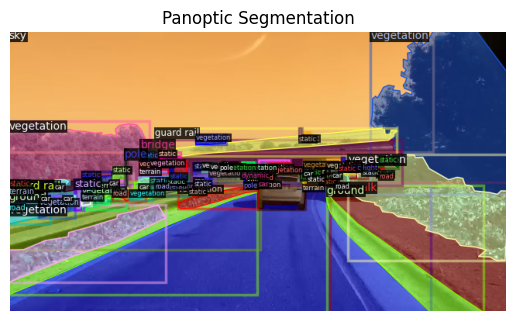

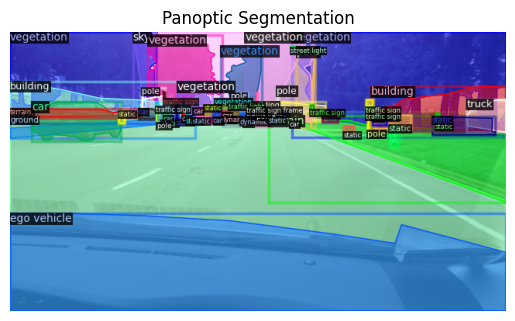

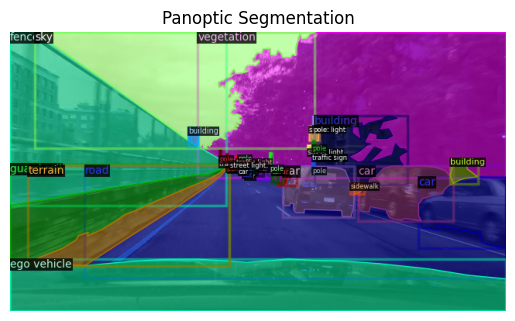

In [5]:
import cv2
import matplotlib.pyplot as plt
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.title("Panoptic Segmentation")
    plt.axis('off')
    plt.show()


In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import os


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))


cfg.DATASETS.TRAIN = ("bdd10k_train",)
cfg.DATASETS.TEST = ()


cfg.DATALOADER.NUM_WORKERS = 2


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")


cfg.SOLVER.IMS_PER_BATCH = 2  
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1   
cfg.SOLVER.STEPS = []        


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 48  
cfg.MODEL.DEVICE = 'cpu'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[07/22 12:05:23 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

KeyboardInterrupt: 

In [ ]:
print(cfg.OUTPUT_DIR)

./output


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

[07/20 18:02:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...


AssertionError: Checkpoint ./output\model_final.pth not found!